# Coursera Capstone - Battle of Zurich
IBM Data Science Professional Certificate - Markus Kessler  
<br/>
  
## Problem Description
Working with all of this loacation based data in the previous lessions, i wonderd if i could implement a regression to predict the pricing of flats around the city of Zurich, Switzerland. The Importance of price-predicting in our fast expanding society is obiquitous and i wonder if i can discover what exactly has an impact on the price of a flat. Nowing what price will come out from data that may be based only on the location can give extreme insight if for instance a bank or a coorporation should invest in a real estate project. 

## Data Description
The data used is scraped off of one of the biggest real estate platform of switzerland, namely ImmoScout24.ch. I want to see if i can form a precise model based on this source as well as additionally generated data like Foursquare Point-Of-Interests, distance to the main station or onehot-encoding derived from the description of a flat i.e. looking for keywords like "new" or "lakeview".

In the process a exploratively application of clustering may show us if flats can be put into groupes, but this will certanly  be more informative rather than the main goal of this assingment.

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from geopy.distance import distance
pd.set_option('display.max_columns', None)

## Data collection
With BeautifulSoup, we collect the information about flats in Zurich in a 10km radius. With a for-loop, we visit every page of the gallery listing the flats. The number of pages can change over time and could be automated for future improvement.

In [4]:
# getting the published empty flats of Zurich in a 10km radius
# IF THIS CELL RETURNS AN ERROR, IT MIGHT CHECK FOR MORE PAGES THAN AVAILABLE
result_list = []
max = 38 #number of web pages to scrape

for i in range(max):
    url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-zuerich?pn={}&r=10'.format(i+1)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_data = soup.find(id='state')
    jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
    data_list = jason_data['pages']['searchResult']['resultData']['listData']

    page_list = []

    for elem in data_list:
        if 'price' in elem: price = elem['price']
        else: price = np.nan

        if 'surfaceLiving' in elem: sl = elem['surfaceLiving']
        else: sl = np.nan

        if 'numberOfRooms' in elem: nor = elem['numberOfRooms']
        else: nor = np.nan

        if 'title' in elem: ttl = elem['title']
        else: ttl = np.nan

        if 'latitude' in elem: lat = elem['latitude']
        else: lat = np.nan

        if 'longitude' in elem: lon = elem['longitude']
        else: lon = np.nan

        page_list.append([elem['id'], price, nor, sl, ttl, elem['zip'], lat, lon])

    result_list += page_list

result_list[10]

[6312102,
 1290,
 1.5,
 35,
 'Ideal für Singles - Moderne Wohnung direkt am Bahnhof!',
 '8603',
 47.38454,
 8.66114]

## Data Preperation

First, we want to derive more possible information about the flat from its title, which acts more like a description. Does it have a beautiful view on the lake? Maybe it just got freshly renovated. With keyword-checking we put together onehot-encoding for the specific attribute.

In [5]:
flats_df = pd.DataFrame(result_list)
flats_df.columns = ['ID', 'Price', 'RoomNr', 'Surface', 'Title', 'ZIP', 'Latitude', 'Longitude']

flats_df.dropna(inplace=True)
flats_df['Title'] = flats_df['Title'].str.lower()

flats_df['Vista'] = 0
filter1 = flats_df['Title'].str.contains('blick|sicht|anstoss')
filter2 = ~flats_df['Title'].str.contains('besichtigung')
flats_df.loc[filter1 & filter2, 'Vista'] = 1

flats_df['Bright'] = 0
filter3 = flats_df['Title'].str.contains("hell|licht|sonnig")
flats_df.loc[filter3, 'Bright'] = 1

flats_df['New'] = 0
filter4 = flats_df['Title'].str.contains("neu|new|saniert")
flats_df.loc[filter4, 'New'] = 1

flats_df['Furnished'] = 0
filter5 = flats_df['Title'].str.contains("möbliert|moebliert|furnished")
flats_df.loc[filter5, 'Furnished'] = 1

flats_df.head()

,ID,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude,Vista,Bright,New,Furnished
0,6297866,2550.0,3.5,95.0,wohnen im aufstrebenden giessenpark,8600,47.40102,8.61187,0,0,0,0
1,6305248,1325.0,1.0,37.0,nähe rigiplatz - ideal für studenten!,8006,47.38452,8.55058,0,0,0,0
2,6304766,1687.0,2.0,50.0,idyllisches wohnquartier,8053,47.35964,8.58249,0,0,0,0
3,5927559,2035.0,3.5,85.0,trio dietikon - zentral und modern,8953,47.40297,8.40607,0,0,0,0
5,6302686,4998.0,4.5,124.0,"4.5-zimmer-wohnung, 12. og, l12.2, 124.6 m2",8004,47.37942,8.53178,0,0,0,0


Now we want to at each individual distance to the Zürich Hauptbahnhof, the main station. For that we use the Distance-Function of GeoPy and apply it on every row of our dataset.

In [6]:
#Adding each flats distance to the Zurich Main Station
def get_station_dist(lat, lon):
    return distance((lat,lon), (47.378,8.540)).kilometers

def row_function(row):
    return get_station_dist(row['Latitude'], row['Longitude'])

flats_df['StationDist'] = flats_df.apply(row_function, axis = 1)
flats_df.head()


,ID,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist
0,6297866,2550.0,3.5,95.0,wohnen im aufstrebenden giessenpark,8600,47.40102,8.61187,0,0,0,0,5.999567
1,6305248,1325.0,1.0,37.0,nähe rigiplatz - ideal für studenten!,8006,47.38452,8.55058,0,0,0,0,1.078770
2,6304766,1687.0,2.0,50.0,idyllisches wohnquartier,8053,47.35964,8.58249,0,0,0,0,3.803460
3,5927559,2035.0,3.5,85.0,trio dietikon - zentral und modern,8953,47.40297,8.40607,0,0,0,0,10.485891
5,6302686,4998.0,4.5,124.0,"4.5-zimmer-wohnung, 12. og, l12.2, 124.6 m2",8004,47.37942,8.53178,0,0,0,0,0.640510


Ofcourse we have to clean out some errors and outliers. In particular occurencies of flats tha have extreme low squaremeters in space. These will influence our price per squaremeter that we want to have as our target variable so they have to be removed.

In [7]:
#Cleaning out statistical outliers and errors
flats_filtered = flats_df[flats_df['Surface'] > 3 ]

As mentioned, following the calculation of the price per squaremeter together with its plot as a histogram. This lets us quickly see that the most occuring price is around CHF 30.- per squaremeter.

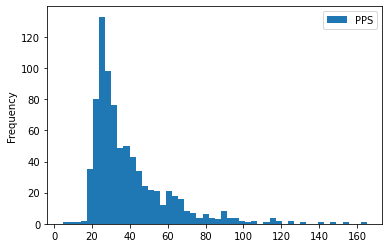

In [8]:
#Calculating price per squaremeter
pps = flats_filtered['Price'] / flats_filtered['Surface']
flats_filtered['PPS'] = pps
flats_filtered[['PPS']].plot.hist(bins=50)

## Visualizing clusters

As a little digression, lets see if we can assign some categories to the flats and visualise it. For that we use the KMeans clustering algorithm and focus on the attributes "Price per square", "Station Distance" and "Vista" that is one if any form of view or lake is mentioned.

In [9]:
cluster_df = flats_filtered.set_index('ID')
cluster_df = cluster_df[['PPS', 'StationDist', 'Vista']]
#cluster_df.dropna(inplace=True)
X = normalize(cluster_df.to_numpy())
#X = cluster_df.to_numpy()
clusters = KMeans(n_clusters=3).fit_predict(X)

Then we combine this gathered category information with our dataset and visualize the flats with the help of a folium map. The color indicate the three clusters.

In [119]:
flats_final = flats_filtered
flats_final['Cat'] = np.array(clusters)

# create map of zurich using latitude and longitude values
map_zurich = folium.Map(location=[47.38, 8.53], zoom_start=11.5)

linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=2
)

# add markers to map
for lat, lng, id, cat in zip(flats_final['Latitude'], flats_final['Longitude'], flats_final.index, flats_final['Cat']):
    label = folium.Popup(str(id), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(cat),
        fill=True,
        fill_color=linear(cat),
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)

map_zurich

Visually we can see at a glance that of course the station distance seperates the flats in to three rings. But if we have a closer look it shows that flats around the lake, along the river Limmat and towards the region Örlikon also get drawn into the same category, that stands for the more expensive ones.


## Integrating Folium data

Now lets put Folium to good use. For every flat we want to gather all points of interests limit to 50 items in a radius of 500 meters. The api-call for venues is exaclty what we want here. At the end we group the gathered information by ID so we have a one-hot encoding for every possible venue, which is around 280 columns wide.

In [13]:
CLIENT_ID = 'VV5H111QRCSXOLD5LF52CDDBI1S1QPDX5BFBOI3IJQHGYI4L' # your Foursquare ID
CLIENT_SECRET = 'TEH4SQMZBUB1VHCJZQYNLNHCQTBLTEXIHBLY1VWM1FMSYU1N' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 500
LIMIT = 50

In [14]:
venues_list=[]

for flatID, flatLat, flatLon in zip(flats_sample['ID'], flats_sample['Latitude'], flats_sample['Longitude']):

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, flatLat, flatLon, VERSION, RADIUS, LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        venues_list.append([
            flatID,
            v['venue']['categories'][0]['name']
        ])

venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['ID', 'Category']

onehot_data = pd.get_dummies(venues_df['Category'],  prefix="", prefix_sep="")
onehot_data['ID'] = venues_df['ID']
onehot_data = onehot_data.groupby('ID').sum()
onehot_data

,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bathing Area,Beach,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Language School,Laser Tag,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nightclub,Non-Profit,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trade School,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

But of course in the end we are only interested in the total number of POIss for every flat, so we create a column at the end with the sum-function. In this cell, i left in the filters because i tried to give the POIs more meaning by filter only (subjectively) importent ones. Surprisingly, this had more of a negative effect on the Outcome.

In [62]:
pois = [
    'Bus Station',
    'Bus Stop',
    'Convenience Store',
    'Discount Store',
    'Grocery Store',
    'Food',
    'Café',
    'Light Rail Station',
    'Market',
    'Shopping Mall',
    'Supermarket',
    'Train Station',
    'Tram Station'
]

#onehot = onehot[pois]
onehot = onehot_data
onehot['sum'] = onehot.sum(axis=1)
onehot

,Accessories Store,Advertising Agency,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bathing Area,Beach,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Language School,Laser Tag,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nightclub,Non-Profit,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trade School,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,sum
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [63]:
fs = flats_sample.set_index('ID')
flats_joined = fs.join(onehot['sum'], how='left')
flats_joined.rename(columns={'sum':'POIS'}, inplace=True)
flats_joined.corr()
#flats_joined['sum'].value_counts()


#filter = flats_joined['RoomNr'] == 3.5
#flats_filtered = flats_joined[filter]


#plt.scatter(flats_joined['POIS'], flats_joined['PPS'])
flats_joined.corr()

,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS,Cat,POIS
Price,1.000000,0.464830,0.634136,-0.228462,0.051546,0.148251,-0.036167,0.070612,0.080387,-0.298032,0.156006,0.033377,0.261573
RoomNr,0.464830,1.000000,0.861091,0.012460,0.040191,0.149685,0.058681,0.177640,-0.277087,0.345558,-0.574463,-0.138504,-0.314859
Surface,0.634136,0.861091,1.000000,-0.025983,0.034945,0.150942,0.055800,0.183768,-0.247987,0.213247,-0.529985,-0.093527,-0.202418
Latitude,-0.228462,0.012460,-0.025983,1.000000,-0.019698,-0.079972,-0.021599,-0.050966,-0.144391,0.290721,-0.212653,-0.012305,-0.137450
Longitude,0.051546,0.040191,0.034945,-0.019698,1.000000,-0.001621,0.011219,-0.017187,0.033140,-0.138528,0.005043,0.200711,0.040883
Vista,0.148251,0.149685,0.150942,-0.079972,-0.001621,1.000000,-0.039317,0.006595,-0.085981,0.039705,-0.044556,-0.014187,-0.093487
Bright,-0.036167,0.058681,0.055800,-0.021599,0.011219,-0.039317,1.000000,0.071432,-0.093984,0.140042,-0.107253,-0.087976,-0.124531
New,0.070612,0.177640,0.183768,-0.050966,-0.017187,0.006595,0.071432,1.000000,-0.126907,0.159026,-0.142452,-0.005676,-0.159684
Furnished,0.080387,-0.277087,-0.247987,-0.144391,0.033140,-0.085981,-0.093984,-0.126907,1.000000,-0.325471,0.427571,0.001506,0.310956
StationDist,-0.298032,0.345558,0.213247,0.290721,-0.138528,0.039705,0.140042,0.159026,-0.325471,1.000000,-0.573536,-0.223827,-0.740696


In [116]:
flats_data = flats_joined.dropna()
X = flats_data[['StationDist', 'POIS', 'RoomNr', 'Surface']]
Y = flats_data[['PPS']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=16)
X.count()

StationDist    802
POIS           802
RoomNr         802
Surface        802
dtype: int64

In [117]:
linMod = LinearRegression(normalize=True)
linMod.fit(X_train, Y_train)

print ('Coefficients: ', linMod.coef_)

Coefficients:  [[-2.16896573  0.3104942  -2.65802081 -0.15146208]]


In [120]:
Y_hat = linMod.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((Y_hat - Y_test) ** 2))
print('Variance score: %.2f' % linMod.score(X_test, Y_test))

Residual sum of squares: 154.02
Variance score: 0.60
